<a href="https://colab.research.google.com/github/Itai1991Ortner/Machine-Learning/blob/main/kicks_with_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split as split ,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier
from sklearn.mixture import GaussianMixture

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
my_path='/content/drive/MyDrive/kickstart/ks-projects-201801.csv'
df=pd.read_csv(my_path,parse_dates=["deadline","launched"])

In [ ]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [ ]:
# create a map of features - to understand the content better
def table_info(df):
    print(f"Dataset Shape: {df.shape}")
    first_check = pd.DataFrame(df.dtypes,columns=['dtypes'])
    first_check = first_check.reset_index()
    first_check['Name'] = first_check['index']
    first_check = first_check[['Name','dtypes']]
    first_check['isnull'] = df.isnull().sum().values    
    first_check['num_Uniques'] = df.nunique().values

    return first_check

In [ ]:
#present the table above
table_info(df)

Dataset Shape: (378661, 15)


,Name,dtypes,isnull,num_Uniques
0,ID,int64,0,378661
1,name,object,4,375764
2,category,object,0,159
3,main_category,object,0,15
4,currency,object,0,14
5,deadline,datetime64[ns],0,3164
6,goal,float64,0,8353
7,launched,datetime64[ns],0,378089
8,pledged,float64,0,62130
9,state,object,0,6


In [ ]:
#base cleaning
df=df.rename(lambda col: col.strip(),axis=1)
df.columns = df.columns.str.replace(' ','_')

df["dates_gap"]=(df["deadline"]-df["launched"]).dt.days
df=df.drop(columns=['ID','name','deadline','launched',"usd_pledged",'goal','usd_goal_real'], axis=1)

Text(0.5, 1.0, 'Target options')

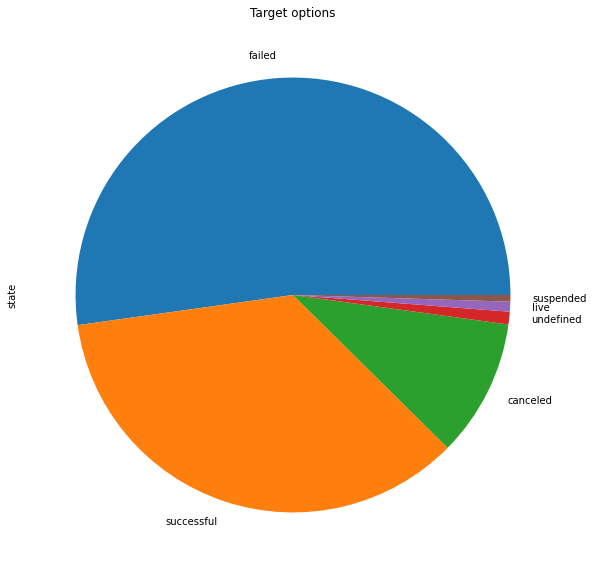

In [ ]:
#target distribution
figure = plt.figure(figsize = (20,10))
df["state"].value_counts().plot.pie()
plt.title('Target options')

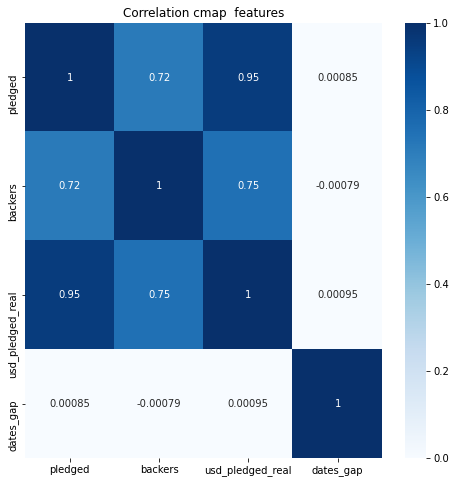

In [ ]:
#correlation heatmap plot
plt.figure(figsize=(8,8))
correl=df.corr()
sns.heatmap(correl,annot=True,cmap='Blues')
plt.title('Correlation cmap  features')
plt.show()

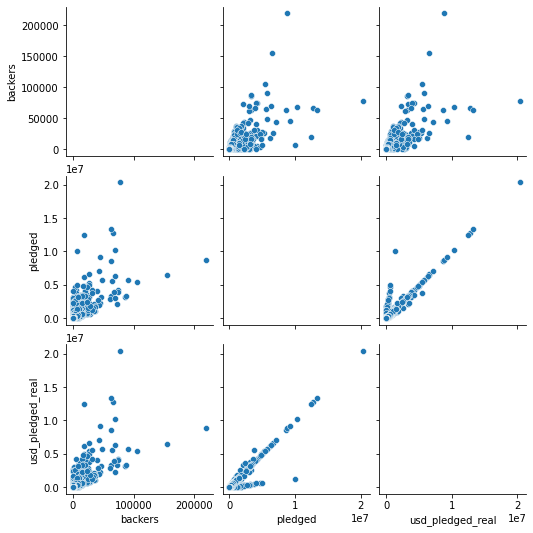

In [ ]:
#plotting connection of any combination of 3 features
pairploting=df[['backers','pledged','usd_pledged_real']]
sns.pairplot(data=pairploting)

In [ ]:
df["state"]=df["state"].replace({'canceled':'failed'}).replace({'live':'other'}).replace({'undefined':'other'}).replace({'suspended':'failed'})

In [ ]:
#initiating X and y
X=df.drop(columns=["state"])
X_numeric=df.drop(columns=["category","main_category","currency","country","state"])
y=df["state"]

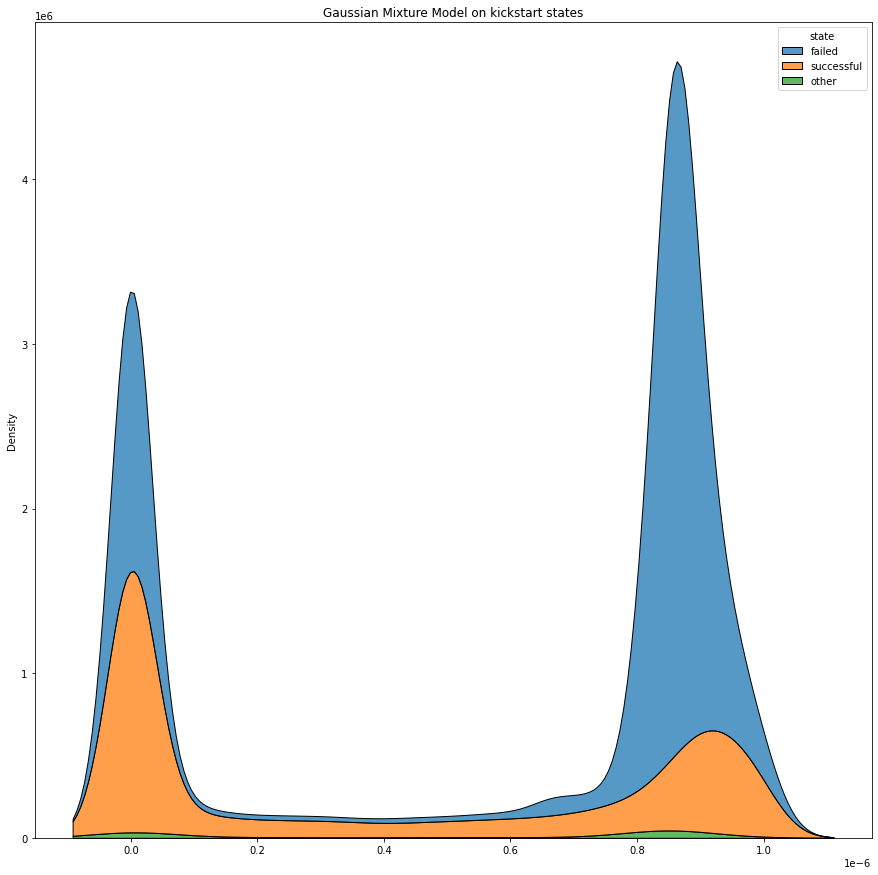

In [ ]:
gmm = GaussianMixture(n_components=2).fit(X_numeric)
samp=gmm.score_samples(X_numeric)
plt.figure(figsize=(15,15))
sns.kdeplot(data=df,x=np.exp(samp),hue="state", fill=True, multiple="stack")
plt.title("Gaussian Mixture Model on kickstart states")
plt.show()

In [ ]:
# method that use PCA to remove outliers
def remove_outliers(X,X_numeric, n_outliers):
  pca = PCA(n_components=3)

  pca.fit(X_numeric)
  X_reconstructed = pca.inverse_transform(pca.transform(X_numeric))
  X_reconstructed = pd.DataFrame(X_reconstructed,index=X_numeric.index,columns = X_numeric.columns)
  errors=((X_reconstructed - X_numeric)**2).sum(axis=1)
    
  X_new =X.join(errors.rename("X_reconstructed"))
  X_new["X_reconstructed"]=X_new["X_reconstructed"]
  X_new=X_new.sort_values(ascending=False,by="X_reconstructed")
  X_new=X_new.iloc[:-1*n_outliers,:]

  return X_new

In [ ]:
#executing the outlier removal
X=remove_outliers(X,X_numeric,100)
y=y[X.index]
X

,category,main_category,currency,pledged,backers,country,usd_pledged_real,dates_gap,X_reconstructed
319002,Publishing,Publishing,CHF,0.00,0,CH,0.00,16738,2.790408e+08
2842,Film & Video,Film & Video,USD,0.00,0,US,0.00,14866,2.200035e+08
48147,Art,Art,USD,0.00,0,US,0.00,14834,2.190552e+08
94579,Theater,Theater,USD,0.00,0,US,0.00,14760,2.168702e+08
75397,Film & Video,Film & Video,USD,0.00,0,US,0.00,14749,2.165464e+08
...,...,...,...,...,...,...,...,...,...
59402,Tabletop Games,Games,USD,27127.84,1186,US,27127.84,33,6.392721e-02
328696,Tabletop Games,Games,USD,154609.99,4451,US,154609.99,33,6.168709e-02
92333,Design,Design,GBP,265397.00,3316,GB,406888.36,34,6.032452e-02
329017,Video Games,Games,GBP,39061.02,1652,GB,65722.78,33,6.010816e-02


In [ ]:
#spliting the Data
X_train,X_test,y_train,y_test=split(X,y, test_size=0.3,random_state=1)

In [ ]:
#one_hot_encoder transformer
class MyOneHotEncoder(TransformerMixin, BaseEstimator):
    
    def __init__(self):
        self.ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")
    
    def fit(self, X, y=None):
        self.ohe.fit(X[["category","main_category","currency","country"]])
        return self
    
    def transform(self, X):
        transformed_data = pd.DataFrame(self.ohe.transform(X[["category","main_category","currency","country"]]))
        numerical_features = X.drop(columns=["category","main_category","currency","country"], axis=1)
        
        return np.concatenate([numerical_features,transformed_data], axis=1)
    def get_feature_names(self):
        pass

In [ ]:
my_ohe = MyOneHotEncoder()
ss     = StandardScaler()

my_Pipeline = Pipeline([("my_ohe", my_ohe), ("my_scaler", ss)])

X_train_scaled=my_Pipeline.fit_transform(X_train)
X_test_scaled=my_Pipeline.transform(X_test)

In [ ]:
my_xgb=XGBClassifier()
rf=RandomForestClassifier()
classifiers=[('my_xgb', my_xgb),('rf',rf)]

clf_voting = VotingClassifier(estimators=classifiers,voting='hard')

learning_rate=[0.05,0.1,0.15,0.2,0.25]
max_depth=[2,3,5,7,10]
n_estimators=[50,100,200]
gamma=[0.0,0.1,0.2,0.3,0.4]
scale_pos_weight=[1,3,5]
max_features=[3,5,7,10]
min_samples_split=[3,5,7,10,20]


vote_params={'my_xgb__learning_rate': learning_rate,
            'my_xgb__max_depth': max_depth,
            'my_xgb__n_estimators': n_estimators,
            'my_xgb__gamma': gamma,
            'my_xgb__scale_pos_weight': scale_pos_weight,
            'my_xgb__objective' : 'multi:softprob',
            'rf__max_depth': max_depth,
            'rf__n_estimators': n_estimators,
            'rf__max_features': max_features,
            'rf__min_samples_split': min_samples_split}


rnd_model=RandomizedSearchCV(clf_voting,vote_params,n_iter=5,scoring='f1_micro',cv=5,n_jobs=-1)


In [ ]:
rnd_model.fit(X_train_scaled,y_train)

In [ ]:
y_pred=rnd_model.predict(X_test_scaled)

In [ ]:
cm_f1_micro_weight =  confusion_matrix(y_true=y_test, y_pred=y_pred)
print(cm_f1_micro_weight)
print(classification_report(y_true=y_test, y_pred=y_pred))

[[64815     0  6612]
 [ 1753     9   160]
 [ 8467     1 31752]]
              precision    recall  f1-score   support

      failed       0.86      0.91      0.89     71427
       other       0.90      0.00      0.01      1922
  successful       0.82      0.79      0.81     40220

    accuracy                           0.85    113569
   macro avg       0.86      0.57      0.57    113569
weighted avg       0.85      0.85      0.84    113569

